# Route Transfer Modeling

In this notebook we will be utilizing the Markov Chain bus transit model as developed by W. Klumpenhouwer to model route transfers between buses. The idea is to start with a transfer point, a stop that has more than one route crossing it. Given that you start on route A which shares a transfer point with route B, what's the likelihood that route A arrives at the transfer point before route B. Using the Markovian Bus model as outlined [here](https://prism.ucalgary.ca/handle/1880/106559) we'll attempt to model this scenario in the city of Calgary. Using
Route 2 (Mt. Pleasant / Killarney 17 Ave.) to transfer over to Route 13 (Mount Royal) at the transfer point stop: NB 8 ST SW @ 14 AV SW.

In [1]:
import sys
sys.path.append("/usr/src/")
from RouteModel.route import Model

In [2]:
db_file = "../thesis_data.db"
route_2_id = 156
route_13_id = 70
transfer_point_stop_id = 1252
early_boundary = 15 # Boundary for maximum early/lateness
late_boundary = 40

In [3]:
## Find distributions at transfer point
route_2_model = Model.from_db(db=db_file, route_id=route_2_id , config_id=1 , dmin=-early_boundary, dmax=late_boundary)
route_2_model.make_lognormal_probabilities()
route_2_seq = None
for seq, stop in enumerate(route_2_model.stop_list):
    if stop.stop_id == transfer_point_stop_id:
        route_2_seq = seq
        break
    
route_2_dist = route_2_model.evolve_to_stop(route_2_seq) 

In [4]:
route_13_model = Model.from_db(db=db_file, route_id=route_13_id , config_id=1 , dmin=-early_boundary, dmax=late_boundary)
route_13_model.make_lognormal_probabilities()
route_13_seq = None
for seq, stop in enumerate(route_13_model.stop_list):
    if stop.stop_id == transfer_point_stop_id:
        route_13_seq = seq
        break
route_13_dist = route_13_model.evolve_to_stop(route_13_seq)

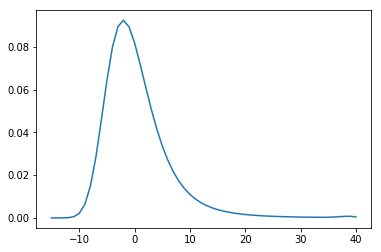

In [5]:
## Sanity check: plot the distributions.
import matplotlib.pyplot as plt
import numpy as np
t = np.arange(route_2_dist.shape[0]) - early_boundary
plt.plot(t,route_2_dist);

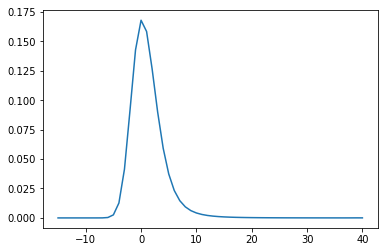

In [6]:
t = np.arange(route_13_dist.shape[0]) - early_boundary
plt.plot(t,route_13_dist);

In [7]:
## Get the distribution of co-ocurrences between arriving early/late between the two routes.
event_dist = np.outer(route_2_dist, route_13_dist)
# Helper function to get the probability
def P(t1, t2):
    reshift_and_bound = lambda x: max(min(event_dist.shape[0],x+early_boundary),0)
    new_t1 = reshift_and_bound(t1)
    new_t2 = reshift_and_bound(t2)
    return event_dist[new_t1,new_t2]
    

Copied from the Calgary Transit website.

 ![](route_2_schedule.png)

 ![](route_13_schedule.png)

Looking at the schedule above, there are a couple different scenarios that one could take to transfer from Route 2 to Route 13. In terms of scheduling offset between the arrivals of the buses they are: 9 minutes, 19 minutes, 1 minute, 6 minutes. Depending on how early/late Route 2 is, route 13 can only then be so early/late minus the amount of scheduled offset. In order to calculate the total probability of according to each schedule we sum the probability of all the possible scenarios where you may make your connection.

In [8]:
## Probability of transfer according to offset
def p_transfer(schedule_offset):
    total_probability = 0.0
    for t_route_2 in range(-early_boundary,late_boundary):
        for t_route_13 in range(t_route_2-schedule_offset, late_boundary):
            total_probability += P(t_route_2, t_route_13)
    return total_probability
            
schedule_offsets = [9, 19, 1, 6]
probability_of_transfer = [p_transfer(offset) for offset in schedule_offsets]

In [9]:
for offset,probability in zip(schedule_offsets,probability_of_transfer):
    print(f"Offset (mins): {offset} -- Probability {probability}")

Offset (mins): 9 -- Probability 0.9396196204617393
Offset (mins): 19 -- Probability 0.9870677855275428
Offset (mins): 1 -- Probability 0.7023991471242242
Offset (mins): 6 -- Probability 0.8915159642976128


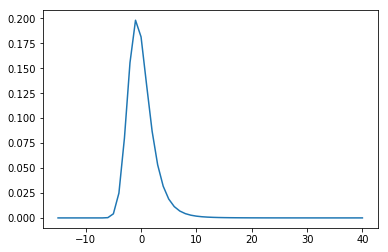

In [23]:
plt.plot(t,route_2_model.evolve_between_stops(route_2_seq-5,route_2_seq));

In [17]:
route_2_seq

25